In [3]:
import os
import time
from glob import glob
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import imageio
import numpy as np
import cv2
from data import SegDataset
from model import build_unet
from loss import DiceLoss, DiceBCELoss
import os
import albumentations as A
import numpy as np
import cv2
import torchvision
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
import imageio
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from torch.utils.data import Dataset

In [3]:

class SegDataset(Dataset):
    def __init__(self, data_path, trans = None):
        super().__init__()

        self.X = sorted(glob(os.path.join(data_path,"images",  "*.tif")))
        self.y = sorted(glob(os.path.join(data_path, "1st_manual", "*.gif")))
        self.trans = trans

    def __getitem__(self, index):
        """ 读取image """
        image = cv2.imread(self.X[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        """ 读取mask """

        mask = Image.open(self.y[index])
        mask = np.array(mask)
        
        if self.trans is not None:
            t = self.trans(image = image, mask = mask)
            image = t['image']
            mask = t['mask']

        return transforms.ToTensor()(image),transforms.ToTensor()(mask)

    def __len__(self):
        return len(self.X)


In [39]:
""" 加载 Dataloader """
trans = A.Compose([
        A.Resize(height=512, width=512, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GaussNoise(p=0.5),
        A.OneOf([
            A.MotionBlur(p=0.2),   # 使用随机大小的内核将运动模糊应用于输入图像。
            A.MedianBlur(blur_limit=3, p=0.1),    # 中值滤波
            A.Blur(blur_limit=3, p=0.1),   # 使用随机大小的内核模糊输入图像。
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        # 随机应用仿射变换：平移，缩放和旋转输入
        A.RandomBrightnessContrast(p=0.2),   # 随机明亮对比度
        A.Normalize(),
])
train_dataset = SegDataset("../train", trans)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


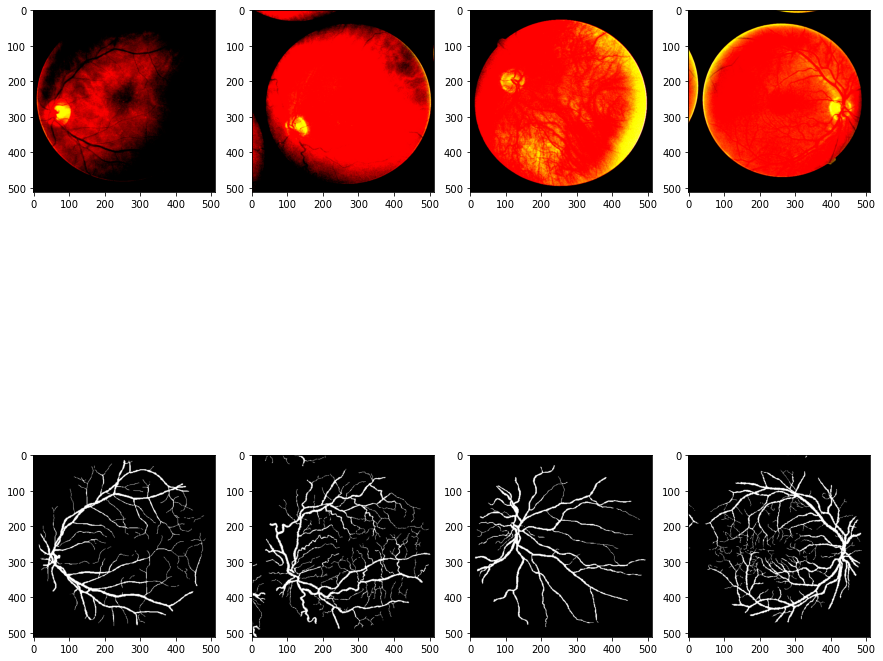

In [42]:

_, axes = plt.subplots(2, 4, figsize = (15,15))
for i,(x, y) in zip(range(4), train_dataset):
    # print(x.shape, y.shape)
    axes[0][i].imshow(np.transpose(x.numpy(),(1,2,0)))
    axes[1][i].imshow(np.transpose(y.numpy(),(1,2,0)), cmap=plt.get_cmap('gray'))    


In [12]:
model = build_unet()
model = model.cuda()
model.load_state_dict(torch.load('files/checkpoint.pth', map_location='cuda:0'))

trans_mask = A.Compose([
            A.Resize(height=512, width=512, p=1.0),
    ])
valid_dataset = SegDataset("../test",trans_mask)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
for i,(x, y) in enumerate(valid_loader):
    x = x.to('cuda:0',dtype=torch.float32)
    y_hat = model(x)
    y_hat = y_hat > 0.1

    print(x.shape, y.shape, y_hat.shape)
    _, axes = plt.subplots(1, 3,figsize = (15,15))
    axes = axes.flatten()
    axes[0].imshow(np.transpose(x[0].detach().cpu().numpy(),(1,2,0)))
    axes[0].set_title("X")
    axes[1].imshow(np.transpose(y[0].numpy(),(1,2,0)), cmap=plt.get_cmap('gray'))
    axes[1].set_title("y")
    axes[2].imshow(np.transpose(y_hat[0].detach().cpu().numpy(),(1,2,0))*255, cmap=plt.get_cmap('gray'))
    axes[2].set_title("y_hat")
    plt.savefig(f'./results/results_{i}.png', bbox_inches='tight')


In [6]:
from torch.utils.tensorboard import SummaryWriter

In [18]:
write1 = SummaryWriter(log_dir= './runs')
write2 = SummaryWriter(log_dir= './runs')
write3 = SummaryWriter(log_dir= './runs')
for i in range(100):
    x = i
    y = x * 2
    c = x * x
    write1.add_scalar('a', x, i+1)
    write2.add_scalar('b', y, i+1)
    write3.add_scalar('c', c, i+1)